## Top-level: Importing packages 'n stuff

In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

In [2]:
# Importing required packages:

# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
%matplotlib inline

# Numba (JiT)
from numba import jit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

# Deep copies
import copy

## Function which enables us to create directories if they don't exist:

In [3]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Defining the velocity field:

In [4]:
@jit(nopython=True)
def doublegyre_wrapper(t,x):
    # Parameters of the velocity field (Cf. Farazmand & Haller, 2012)
    # A
    A = 0.1
    # epsilon
    e = 0.1
    # omega
    w = 2*np.pi/10
    return _doublegyre(t,x,A,e,w)

@jit(nopython=True)
def _doublegyre(t,x,A,e,w):
    # a(t)
    a = e * np.sin(w*t)       
    # b(t)
    b = 1 - 2*e*np.sin(w*t)  
    # f(x,t)
    f = a*x[0,:]**2 + b*x[0,:]
    # df/dx
    dfdx = 2*a*x[0,:] + b
    
    v = np.empty(x.shape)                         
    # x-component:
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:])
    # y-component:
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*dfdx
    return v 

# Function which generates a grid of particles

In [5]:
def grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x = np.linspace(x_min,x_max,nx)
    y = np.linspace(y_min,y_max,ny)
    
    grid = np.empty((2,nx*ny))
    
    for j in range(n_x):
        grid[0,j*ny:(j+1)*ny] = x[j]
        grid[1,j*ny:(j+1)*ny] = y
        
    return grid

def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid
    
    

# List of implemented fixed step integrators
## Relevant for saving/loading advected states

In [6]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function which advects a set of initial conditions, including auxiliary grid points

In [7]:
# Input: (numpy) array of coordinates, shape: (5,2,nx*ny), [grid,x,y]
def endpoints(t_start,t_end,pos_start,stride,integrator,rhs,n_proc,atol,rtol):
    pos_end = np.empty(np.shape(pos_start))
    
    n_tot = np.size(pos_start,2)
    part = np.floor(n_tot/n_proc).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    
    if integrator.__name__ in fixed_step_integrators:
        plist = [mp.Process(target=_endpoints_fixed,
                           args=(t_start,t_end,pos_start[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part],
                                stride,integrator,rhs,j,qlist[j])) for j in range(n_proc)]
    else:
        plist = [mp.Process(target=_endpoints_adaptive,
                           args=(t_start,t_end,pos_start[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part],
                                stride,integrator,rhs,j,qlist[j],atol,rtol)) for j in range(n_proc)]
    
    for p in plist:
        p.start()
    for j, q in enumerate(qlist):
        pos_end[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part] = q.get()
    for p in plist:
        p.join()
    
    return pos_end

def _endpoints_fixed(t_start,t_end,pos_start,stride,integrator,rhs,pn,q):
    pos_fin = np.copy(pos_start)
    for j in range(np.size(pos_fin,0)):
        t = np.copy(t_start).astype(float)
        h = np.copy(stride).astype(float)
        while t<t_end:
            h = np.minimum(h,t_end-t)
            t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    q.put(pos_fin)
    
def _endpoints_adaptive(t_start,t_end,pos_start,stride,integrator,rhs,pn,q):
    pos_fin = np.copy(pos_start)
    for j in range(np.size(pos_fin,0)):
        t = np.copy(t_start).astype(float)
        h = np.copy(stride).astype(float)
        while t<t_end:
            h = np.minimum(h,t_end-t)
            t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    q.put(pos_fin)

# Function which computes the characteristics for given grid parameters

In [8]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,rhs,trunc_dec,n_proc=4,atol=None,rtol=None):
    grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    grid_fin,lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,trunc_dec,n_proc,atol,rtol)
    
    return grid,grid_fin,lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,trunc_dec,n_proc,atol,rtol):
    grid_ = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    # Grid: Main -> Right -> Above -> Left -> Beneath
    grid = np.empty((5,2,(nx+4)*(ny+4)))
    grid[0] = np.copy(grid_)
    grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
    grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
    grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
    grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
    
    grid = 10**-(trunc_dec)*np.floor(endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)*10**trunc_dec)
    
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    lapl_lmbd2,lapl_xi2 = _find_laplacians(lmbd2,xi2,nx,ny,dx_main,dy_main)
    
    return grid[0].reshape(2,nx+4,ny+4),lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((2,2,nx+4,ny+4))
    df_a = np.empty((2,2,nx+4,ny+4))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[0,0,:,:] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[0,1,:,:] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[1,0,:,:] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[1,1,:,:] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[0,0,1:-1,:] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,0,0,:] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[0,0,-1,:] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[0,1,:,1:-1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[0,1,:,0] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[0,1,:,-1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1,0,1:-1,:] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[1,0,0,:] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[1,0,-1,:] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[1,1,:,1:-1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[1,1,:,0] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[1,1,:,-1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape((2,2,(nx+4)*(ny+4)))
    df_m = df_m.reshape((2,2,(nx+4)*(ny+4)))
    
    # Declare strain tensors:
    c_m = np.empty(np.shape(df_m))
    c_a = np.empty(np.shape(df_a))
    
    # Explicitly calculate strain tensors:
    for j in range((nx+4)*(ny+4)):
        c_m[:,:,j] = np.dot(df_m[:,:,j].T,df_m[:,:,j])
        c_a[:,:,j] = np.dot(df_a[:,:,j].T,df_a[:,:,j])
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    lmbd1 = np.empty(np.size(tens_main,2))
    lmbd2 = np.empty(np.shape(lmbd1))
    xi1 = np.empty((2,np.size(tens_main,2)))
    xi2 = np.empty(np.shape(xi1))
    
    for j in range(np.size(lmbd1)):
        # Linalg.eigh returns eigenvalues and vectors
        # sorted by increasing magnitude of eigenvalues
        vals, foo = np.linalg.eigh(tens_main[:,:,j])
        bar, vecs = np.linalg.eigh(tens_aux[:,:,j])
        
        lmbd1[j] = vals[0]
        lmbd2[j] = vals[1]
        
        xi1[:,j] = vecs[:,0]
        xi2[:,j] = vecs[:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_laplacians(lmbd,xi,nx,ny,dx_main,dy_main):
    lmbd_ = lmbd.reshape((nx+4,ny+4))
    xi_ = xi.reshape((2,nx+4,ny+4))
    
    lapl_lmbd = np.empty(np.shape(lmbd_))
    lapl_xi = np.empty(np.shape(xi_))
    
        # First direction:
    # Use centered differencing for internal points
    lapl_lmbd[1:-1,:] = (lmbd_[2:,:]-2*lmbd_[1:-1,:]+lmbd_[0:-2,:])/(dx_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_lmbd[0,:] = (2*lmbd_[0,:]-5*lmbd_[1,:]+4*lmbd_[2,:]-lmbd_[3,:])/(dx_main**2)
    lapl_lmbd[-1,:] = (2*lmbd_[-1,:]-5*lmbd_[-2,:]+4*lmbd_[-3,:]-lmbd_[-4,:])/(dx_main**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl_lmbd[:,1:-1] += (lmbd_[:,2:]-2*lmbd_[:,1:-1]+lmbd_[:,0:-2])/(dy_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_lmbd[:,0] += (2*lmbd_[:,0]-5*lmbd_[:,1]+4*lmbd_[:,2]-lmbd_[:,3])/(dy_main**2)
    lapl_lmbd[:,-1] += (2*lmbd_[:,-1]-5*lmbd_[:,-2]+4*lmbd_[:,-3]-lmbd_[:,-4])/(dy_main**2)
    
    # First direction:
    # Use centered differencing for internal points
    lapl_xi[:,1:-1,:] = (xi_[:,2:,:]-2*xi_[:,1:-1,:]+xi_[:,0:-2,:])/(dx_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_xi[:,0,:] = (2*xi_[:,0,:]-5*xi_[:,1,:]+4*xi_[:,2,:]-xi_[:,3,:])/(dx_main**2)
    lapl_xi[:,-1,:] = (2*xi_[:,-1,:]-5*xi_[:,-2,:]+4*xi_[:,-3,:]-xi_[:,-4,:])/(dx_main**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl_xi[:,:,1:-1] += (xi_[:,:,2:]-2*xi_[:,:,1:-1]+xi_[:,:,0:-2])/(dy_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_xi[:,:,0] += (2*xi_[:,:,0]-5*xi_[:,:,1]+4*xi_[:,:,2]-xi_[:,:,3])/(dy_main**2)
    lapl_xi[:,:,-1] += (2*xi_[:,:,-1]-5*xi_[:,:,-2]+4*xi_[:,:,-3]-xi_[:,:,-4])/(dy_main**2)
    
    lapl_lmbd = lapl_lmbd.reshape((nx+4)*(ny+4))
    lapl_xi = lapl_xi.reshape((2,(nx+4)*(ny+4)))
    
    return lapl_lmbd,lapl_xi
    

# Define transport parameters

In [9]:
from numerical_integrators.singlestep import rk4
t_start = 0.
t_end = 20.
h = 0.1

integrator = rk4

x_min,x_max = 0,2
y_min,y_max = 0,1

trunc_dec = 12

nx,ny = 200,100



# Perform transport

In [10]:
grid_,grid_fin,lmbd1_,lmbd2_,lapl_lmbd2_,xi1_,xi2_,lapl_xi2_ = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,h,doublegyre_wrapper,trunc_dec)

_inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
_inner_mask[2:-2,2:-2] = True
_inner_mask = _inner_mask.reshape((nx+4)*(ny+4))

grid = grid_[:,_inner_mask]
x_ = grid_[0,::ny+4]
y_ = grid_[1,:ny+4]
x = x_[2:-2]
y = y_[2:-2]
lmbd1 = lmbd1_[_inner_mask]
lmbd2 = lmbd2_[_inner_mask]
lapl_lmbd2 = lapl_lmbd2_[_inner_mask]
xi1 = xi1_[:,_inner_mask]
xi2 = xi2_[:,_inner_mask]
lapl_xi2 = lapl_xi2_[:,_inner_mask]

In [ ]:
grid_fin[0,150,42]

In [ ]:
l1 = lmbd1.reshape(nx,ny)

In [ ]:
l1[21,19]

# Find (A,B)-domain

In [11]:
def find_ab_mask(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    a = _a_true(lmbd1,lmbd2)
    b = _b_true(lapl_lmbd2,xi2)
    return np.logical_and(a,b)

def _a_true(lmbd1,lmbd2):
    return np.logical_and(lmbd1 is not lmbd2, lmbd2 > 1)

def _b_true(lapl_lmbd2,xi2):
    return np.less_equal(np.sum(xi2*lapl_lmbd2*xi2,axis=0),0)

def _b_true2(lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    return np.less_equal(np.sum(xi2*(lapl_lmbd2*xi2+lmbd2*lapl_xi2),axis=0),0)

def find_ab_mask2(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    a = _a_true(lmbd1,lmbd2)
    b2 = _b_true2(lmbd2,lapl_lmbd2,xi2,lapl_xi2)
    return np.logical_and(a,b2)

# Plot (A,B)-domain

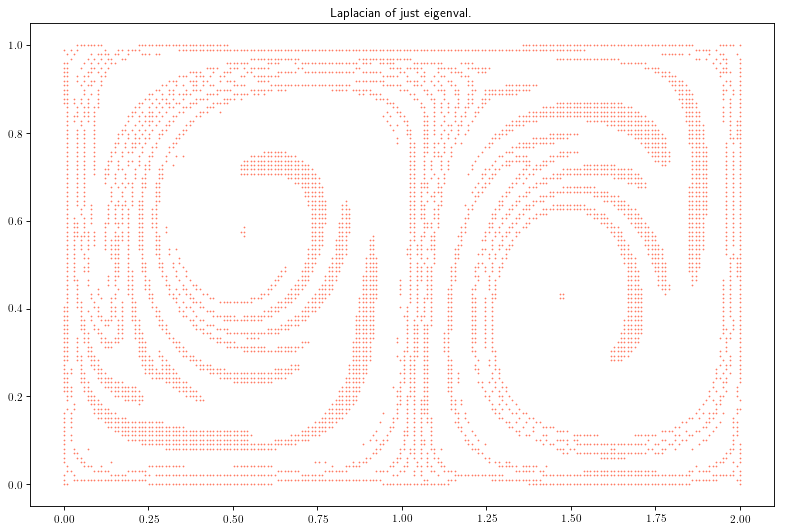

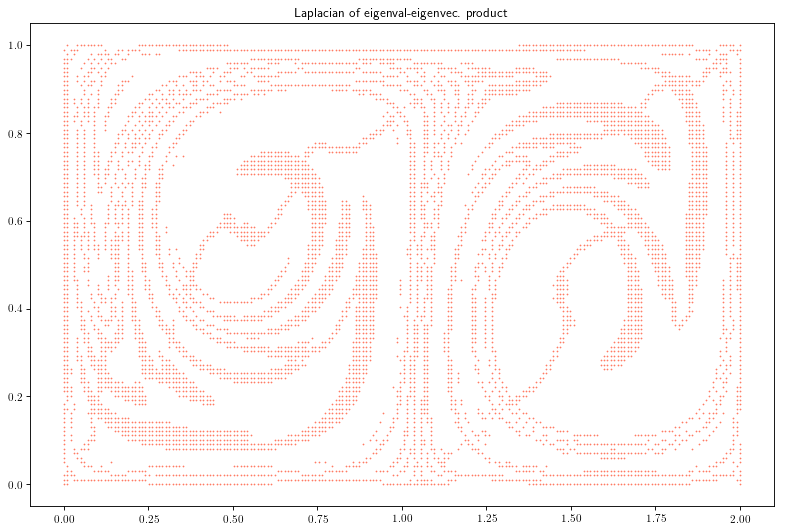

In [12]:
mask_ab = find_ab_mask(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2)
mask_ab2 = find_ab_mask2(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2)

plt.figure(figsize=(12,8),dpi=80)
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],s=1,marker='.',c='tomato')
plt.title('Laplacian of just eigenval.')

plt.figure(figsize=(12,8),dpi=80)
plt.scatter(grid[0,mask_ab2],grid[1,mask_ab2],s=1,marker='.',c='tomato')
plt.title('Laplacian of eigenval-eigenvec. product')

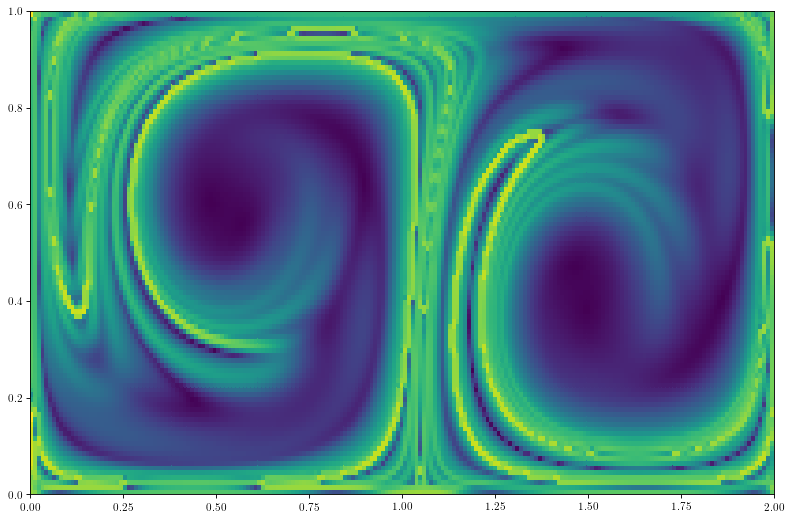

In [15]:
plt.figure(figsize=(12,8),dpi=80)
plt.pcolormesh(np.meshgrid(y,x)[1],np.meshgrid(y,x)[0],np.log(np.abs(lmbd2.reshape(nx,ny)+1))/(2*np.abs(t_end)))

# Function which finds $\mathcal{G_{0}}$

In [16]:
def find_g0(nx,ny,num_horz,num_vert):
    mask = np.zeros((nx,ny),dtype=bool)
    stride_horz = np.floor(nx/(num_horz+1)).astype(int)
    stride_vert = np.floor(ny/(num_vert+1)).astype(int)
    
    for j in range(1,num_vert+1):
        mask[np.minimum(j*stride_horz,nx-1),:] = True
    for j in range(1,num_horz+1):
        mask[:,np.minimum(j*stride_vert,ny-1)] = True
    
    mask = mask.reshape(nx*ny)
    
    return mask

# Choose no. of vert. and horz. lines in $\mathcal{G}_{0}$

In [17]:
num_horz = 4
num_vert = 4

# Find and plot $\mathcal{G}_{0}$

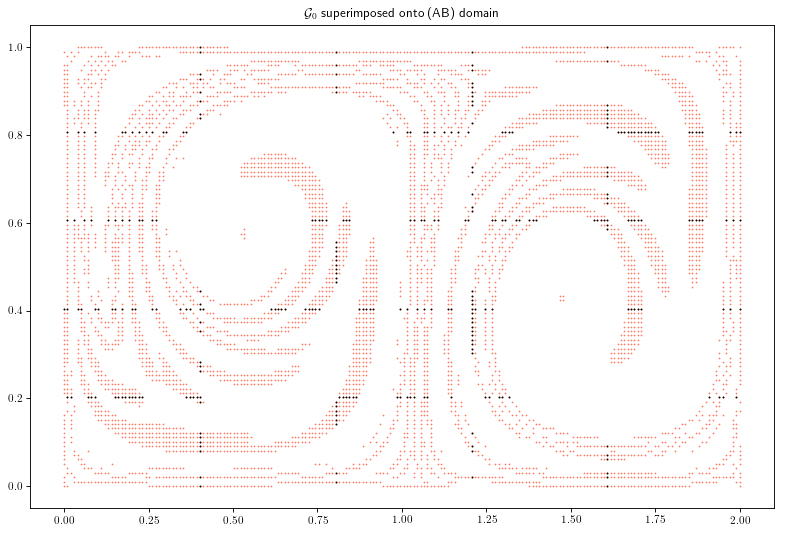

In [18]:
mask_g0 = find_g0(nx,ny,num_horz,num_vert)

g0 = grid[:,np.logical_and(mask_g0,mask_ab)]

plt.figure(figsize=(12,8),dpi=80)
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],marker='.',s=1,c='tomato')
plt.scatter(g0[0],g0[1],marker='.',s=2,c='k')
plt.title(r'$\mathcal{G}_{0}$ superimposed onto (AB) domain')

# Functions which advect strainlines

In [30]:
class InABDomain:
    def __init__(self,pos_init,lmbd1,lmbd2,lapl_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lapl_lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lapl_lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    
    def _normalize(self,xi):
        norm = np.sqrt(xi[0]**2+xi[1]**2)
        return xi/norm
        
    def __call__(self,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        lapl_lmbd2 = self._lapl_lmbd2_spline.ev(pos[1],pos[0])
        xi2 = np.array([self._xi2_x_spline.ev(pos[1],pos[0]),self._xi2_y_spline.ev(pos[1],pos[0])])
        xi2 = self._normalize(xi2)
        return ((lmbd1 is not lmbd2) and (lmbd2 > 1) and (np.dot(xi2,lapl_lmbd2*xi2) <= 0))
    

    #def __init__(self,pos_init,mask_a,mask_b,thresh=0.9):
    #    self.inAB_domain_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],np.logical_and(mask_a,mask_b).T,kx=0,ky=0)
    #    self.thresh = thresh
        
    #def __call__(self,pos):
    #    return self.inAB_domain_spline.ev(pos[1],pos[0]) > self.thresh
    
class InNumericalDomain:
    def __init__(self,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._x_min = x_min-(x_max-x_min)*padding_factor
        self._x_max = x_max+(x_max-x_min)*padding_factor
        self._y_min = y_min-(y_max-y_min)*padding_factor
        self._y_max = y_max+(y_max-y_min)*padding_factor
    
    def __call__(self,pos):
        return pos[0] >= self._x_min and pos[0] <= self._x_max and pos[1] >= self._y_min and pos[1] <= self._y_max

    

class RescaledSplinedDerivative:
    def __init__(self,pos_init,lmbd1,lmbd2,xi1,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi1_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi1[0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi1_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi1[1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._prev = None
        #self._reversed = False
        
    def set_previous(self,prev):
        self._prev = prev
        
    def _alpha(self,t,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        
        return ((lmbd1-lmbd2)/(lmbd1+lmbd2))**2
    
    def _normalize(self,xi1_x,xi1_y):
        norm = np.sqrt(xi1_x**2+xi1_y**2)
        return xi1_x/norm, xi1_y/norm
    
    #def _reverse(self):
    #    self._reversed = True
        
    def __call__(self,t,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        alpha = self._alpha(t,pos)
        #if self._reversed:
        xi1_x = self._xi1_x_spline.ev(pos[1],pos[0])
        xi1_y = self._xi1_y_spline.ev(pos[1],pos[0])
        #else:
        #    xi1_x = self._xi1_x_spline.ev(pos[1],pos[0])
        #    xi1_y = self._xi1_y_spline.ev(pos[1],pos[0])
        
        xi1_x, xi1_y = self._normalize(xi1_x,xi1_y)
        
        new = np.array([xi1_x,xi1_y])
        #new = alpha*np.array([xi1_x,xi1_y])
        
        if self._prev is None:
            #if not self._reversed:
            sign = 1
            #else:
            #    sign = -1
        else:
            sign = np.sign(np.dot(self._prev,new))
        
        return sign*new 
    
class Strainline:
    def __init__(self,startpoint,pos_init,lmbd1_spline,lmbd2_spline,l_min,l_f_max):
        self._pos = [startpoint.T]
        self._lmbd1_spline = lmbd1_spline
        self._lmbd2_spline = lmbd2_spline
        self._length = 0.
        self._minimum_length = l_min
        self._sufficient_length = False
        self._maximum_continious_failure_length = l_f_max
        self._continious_failure_length = 0.
        self._continious_failure = False
        self._stationary_endpoint = False
        self._num_points = 1
    
    def current_alpha(self):
        lmbd1 = self._lmbd1_spline.ev(self.current_position()[1], self.current_position()[0])
        lmbd2 = self._lmbd2_spline.ev(self.current_position()[1], self.current_position()[0])
        return ((lmbd1-lmbd2)/(lmbd1+lmbd2))**2
    
    def current_position(self):
        return np.asarray(self._pos[-1])
    
    def long_enough(self):
        return self._sufficient_length
    
    def _is_long_enough(self):
        self._sufficient_length = True
    
    def failed_continiously(self):
        return self._continious_failure
    
    def _has_failed_continiously(self):
        self._continious_failure = True
    
    def _set_continious_failure_length(self,length):
        self._continious_failure_length = length
    
    def reached_stationary_point(self):
        return self._stationary_endpoint
    
    def _has_reached_stationary_point(self):
        self._stationary_endpoint = True
    
    def get_length(self):
        return self._length
    
    def get_continious_failure_length(self):
        return self._continious_failure_length
    
    def get_num_points(self):
        return self._num_points
    
    def _set_length(self,length):
        self._length = length
        
    def _append(self,pos):
        self._pos.append(pos.T)
        self._num_points += 1
        
    def average_lmbd2(self):
        return np.mean(self._lmbd2_spline.ev(self.entire_trajectory()[:,1],self.entire_trajectory()[:,0]))
    
    def entire_trajectory(self):
        return np.asarray(self._pos)
    
    def _merge(self,other):
        self._pos = self._pos[::-1] + other._pos[1:]
        self._num_points += other._num_points - 1
        self._length += other._length
        self._sufficient_length = self._length > self._minimum_length
        self._continious_failure = self._continious_failure or other._continious_failure
        self._stationary_endpoint = self._stationary_endpoint or other._stationary_endpoint
        
def _merge_backwards_and_forwards_parts(strainlines_backwards,strainlines_forwards):
    strainlines = copy.deepcopy(strainlines_backwards)
    for j in range(len(strainlines)):
        strainlines[j]._merge(strainlines_forwards[j])
    return strainlines
    
def advect_strainlines_in_parallel(pos_g0,max_iter,integrator,stride,l_f_max,l_min,tol_alpha,pos_init,lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,x_min,x_max,y_min,y_max,padding_factor=0.1,n_proc=4):
    in_AB_domain = InABDomain(pos_init,lmbd1,lmbd2,lapl_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01)
    #in_AB_domain = InABDomain(pos_init,a_true(lambda1,lambda2),b_true(lambda1,lambda2))
    in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,padding_factor=0.01)
    
    lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    
    rhs = RescaledSplinedDerivative(pos_init,lmbd1,lmbd2,xi1,x_min,x_max,y_min,y_max,padding_factor)
    
    # First, we integrate forwards
    # Container for all strainlines
    strainlines_forwards = [Strainline(pos_g0[:,j],pos_init,lmbd1_spline,lmbd2_spline,l_min,l_f_max) for j in range(np.size(pos_g0,1))]
    
    # Partition distributed to each process:
    partition = np.floor(np.size(pos_g0,1)/n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    processlist = [mp.Process(target=_advect_strainline_slice,
                             args=(strainlines_forwards[j*partition:np.size(strainlines_forwards,0) if j+1 is n_proc else (j+1)*partition],
                                   max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB_domain,
                                   in_numerical_domain,j,queuelist[j])) for j in range(n_proc)]
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        strainlines_forwards[j*partition:np.size(strainlines_forwards,0) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
        
    print('Forwards integration finished. Now integrating backwards:')
        
    # The, we integrate backwards:
    # Container for all strainlines
    strainlines_backwards = [Strainline(pos_g0[:,j],pos_init,lmbd1_spline,lmbd2_spline,l_min,l_f_max) for j in range(np.size(pos_g0,1))]
    
    for i,strainline in enumerate(strainlines_backwards):
        strainline._append(strainline.current_position() - (strainlines_forwards[i].entire_trajectory()[1,:] - strainline.current_position()))
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    # Important: REVERSE the eigenvector spline
    #rhs._reverse()
    processlist = [mp.Process(target=_advect_strainline_slice_backwards,
                             args=(strainlines_backwards[j*partition:np.size(strainlines_backwards,0) if j+1 is n_proc else (j+1)*partition],
                                   max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB_domain,
                                   in_numerical_domain,j,queuelist[j])) for j in range(n_proc)]
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        strainlines_backwards[j*partition:np.size(strainlines_backwards,0) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
    
    #strainlines = _merge_forwards_and_backwards_parts(strainlines_backwards,strainlines_forwards)
    
    
    print('Backwards integration also finished. Results concatenated.')
    
    return strainlines_forwards,strainlines_backwards,_merge_backwards_and_forwards_parts(strainlines_backwards,strainlines_forwards)
    #return strainlines_backwards,strainlines_forwards

def _advect_strainline_slice(strainlines,max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB,in_domain,pn,q):
    for count, strainline in enumerate(strainlines):

        rhs.set_previous(None)
        t = 0.
        iteration = 0
        L = 0.
        L_f = 0.
        #rhs.set_previous(rhs(t,strainline.current_position()))
        #prev_rhs = #rhs(t,strainline.current_position())
        t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        #rhs.set_previous(pos_trial)
        iteration+=1
        while iteration<max_iter and in_domain(pos_trial) and strainline.current_alpha() > tol_alpha and not strainline.failed_continiously():
            #print('Process {}: Called for strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
            if t_trial is not t:
                L += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                if not in_AB(pos_trial):
                    L_f += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                else:
                    L_f = 0.
                rhs.set_previous(rhs(t,strainline.current_position()))
                t = t_trial
                strainline._append(pos_trial)
                if L_f > l_f_max:
                    strainline._has_failed_continiously()
                    strainline._set_continious_failure_length(L_f)
                iteration+=1
            #prev_rhs = rhs(t,strainline.current_position())
            t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        if L > l_min:
            strainline._set_length(L)
            strainline._is_long_enough()
        if strainline.current_alpha() <= tol_alpha:
            strainline._has_reached_stationary_point()
        if not (np.mod(count +  1 +  np.floor(np.size(strainlines,0)/4).astype(int), np.floor(np.size(strainlines,0)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
    q.put(strainlines)               
                          
def _advect_strainline_slice_backwards(strainlines,max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB,in_domain,pn,q):
    for count, strainline in enumerate(strainlines):

        rhs.set_previous((strainline.current_position() - strainline._pos[0])/stride)
        t = 0.
        iteration = 1
        L = 0.
        L_f = 0.
        #rhs.set_previous(rhs(t,strainline.current_position()))
        #prev_rhs = #rhs(t,strainline.current_position())
        t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        #rhs.set_previous(pos_trial)
        iteration+=1
        while iteration<max_iter and in_domain(pos_trial) and strainline.current_alpha() > tol_alpha and not strainline.failed_continiously():
            #print('Process {}: Called for strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
            if t_trial is not t:
                L += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                if not in_AB(pos_trial):
                    L_f += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                else:
                    L_f = 0.
                rhs.set_previous(rhs(t,strainline.current_position()))
                t = t_trial
                strainline._append(pos_trial)
                if L_f > l_f_max:
                    strainline._has_failed_continiously()
                    strainline._set_continious_failure_length(L_f)
                iteration+=1
            #prev_rhs = rhs(t,strainline.current_position())
            t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        if L > l_min:
            strainline._set_length(L)
            strainline._is_long_enough()
        if strainline.current_alpha() <= tol_alpha:
            strainline._has_reached_stationary_point()
        if not (np.mod(count +  1 +  np.floor(np.size(strainlines,0)/4).astype(int), np.floor(np.size(strainlines,0)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
    q.put(strainlines)               

# Advect strainlines

In [31]:
max_iter = 1000
stride = 0.0005
l_f_max = 0.2
l_min = 1
tol_alpha = 1.e-6

tic = time.time()
strainlines_forwards,strainlines_backwards,strainlines = advect_strainlines_in_parallel(g0,max_iter,integrator,stride,l_f_max,l_min,tol_alpha,grid.reshape(2,nx,ny),lmbd1.reshape(nx,ny),lmbd2.reshape(nx,ny),lapl_lmbd2.reshape(nx,ny),xi1.reshape(2,nx,ny),xi2.reshape(2,nx,ny),x_min,x_max,y_min,y_max)
toc = time.time()

print('Elapsed time: {} seconds'.format(toc-tic))

Process 0: Finished integrating strainline candidate 18 of 74
Process 1: Finished integrating strainline candidate 18 of 74
Process 2: Finished integrating strainline candidate 18 of 74
Process 3: Finished integrating strainline candidate 19 of 77
Process 0: Finished integrating strainline candidate 36 of 74
Process 1: Finished integrating strainline candidate 36 of 74
Process 2: Finished integrating strainline candidate 36 of 74
Process 3: Finished integrating strainline candidate 38 of 77
Process 0: Finished integrating strainline candidate 54 of 74
Process 1: Finished integrating strainline candidate 54 of 74
Process 2: Finished integrating strainline candidate 54 of 74
Process 3: Finished integrating strainline candidate 57 of 77
Process 0: Finished integrating strainline candidate 72 of 74
Process 1: Finished integrating strainline candidate 72 of 74
Process 2: Finished integrating strainline candidate 72 of 74
Process 3: Finished integrating strainline candidate 76 of 77
Forwards

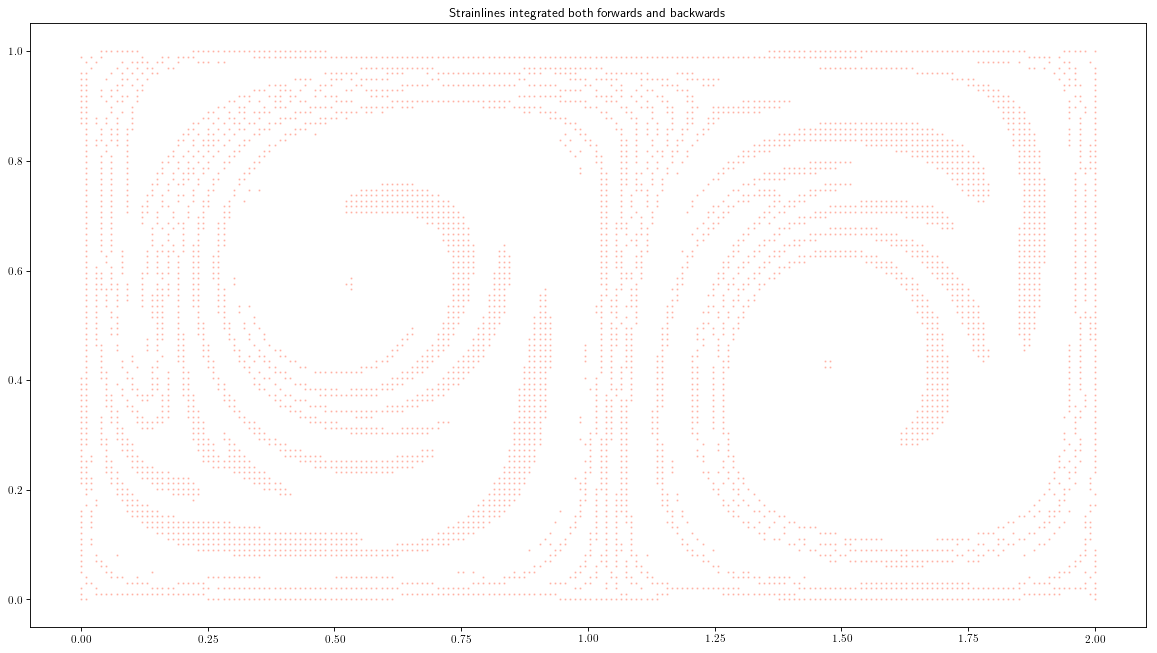

In [32]:
plt.figure(figsize=(18,10),dpi=80)
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,alpha=0.3)
for strainline in strainlines:
    if strainline.long_enough():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],marker='.',s=2,c='k')
        
plt.title(r'Strainlines integrated both forwards and backwards')
plt.show()

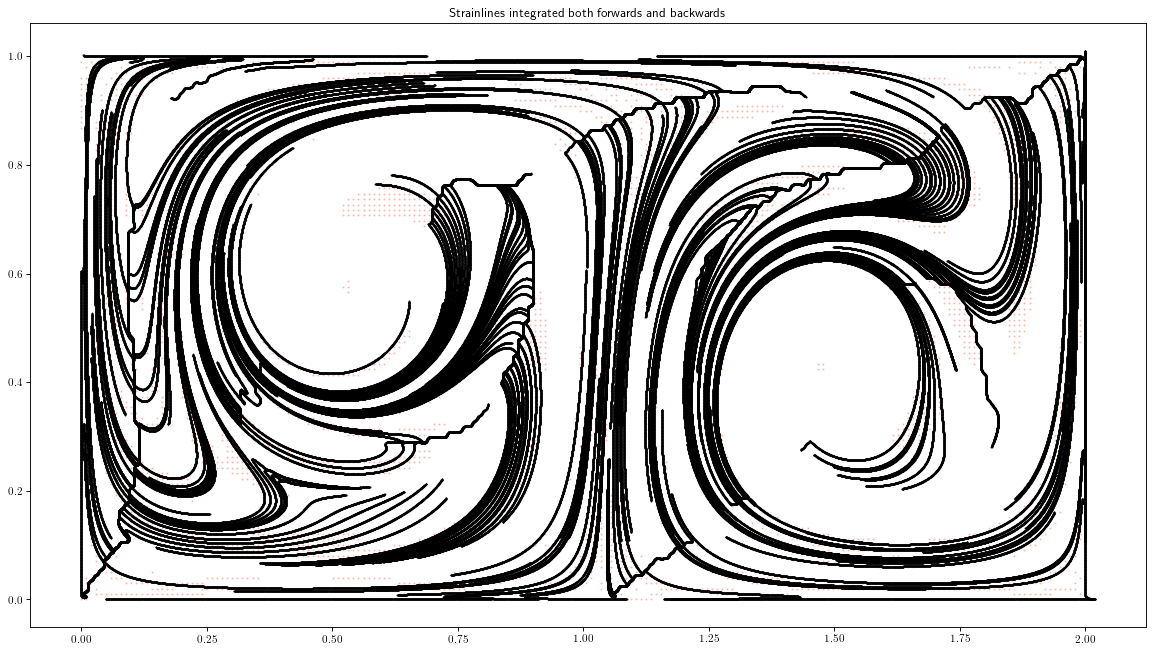

In [33]:
plt.figure(figsize=(18,10),dpi=80)
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,alpha=0.3)
for strainline in strainlines:
    #if strainline.long_enough():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],marker='.',s=2,c='k')
        
plt.title(r'Strainlines integrated both forwards and backwards')
plt.show()

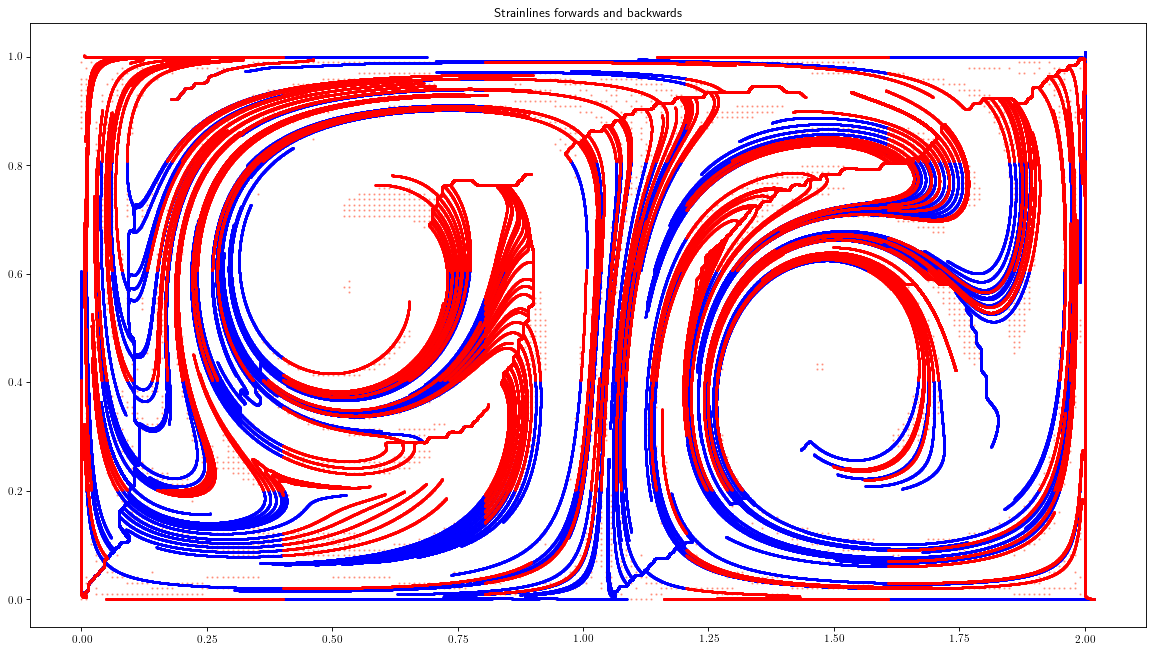

In [34]:
plt.figure(figsize=(18,10),dpi=80)
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,alpha=0.5)
for strainline in strainlines_forwards:
    #if strainline.long_enough(): #and not strainline.has_failed_continiously():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],s=2,c='b')
for strainline in strainlines_backwards:
    #if strainline.long_enough():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],s=2,c='r')

plt.title(r'Strainlines forwards and backwards')
#plt.xlim(1.45,1.8)
#plt.ylim(0.35,0.75)
plt.show()


# Attempt 2: Advect strainlines using special linear interpolation

In [38]:
class LinearSpecialDerivative:
    def __init__(self,nx,ny,grid_,xi1_):
        self._grid = grid_.reshape(2,nx,ny)
        self._dx = self._grid[0,1,0]-self._grid[0,0,0]
        self._dy = self._grid[1,0,1]-self._grid[1,0,0]
        self._xi1 = xi1_.reshape(2,nx,ny)
        self._prev = None
    #    self._reversed = False
        
    def set_previous(self,prev):
        self._prev = prev
        
    def _normalize(self,xi1):
        norm = np.sqrt(xi1[0]**2+xi1[1]**2)
        return xi1/norm
    
    #def _reverse(self):
    #    self._reversed = True
        
    def __call__(self,t,pos):
        i = int(np.maximum(0,np.minimum(pos[0]/self._dx,np.size(self._grid,1)-2)))
        j = int(np.maximum(0,np.minimum(pos[1]/self._dy,np.size(self._grid,2)-2)))
        
        subxi1 = self._xi1[:,i:i+2,j:j+2]
        
        # Choose pivot vector and fix directions of others based on this one
        for ii in range(2):
            for jj in range(2):
                if ii is 0 and jj is 0:
                    pass
                else:
                    subxi1[:,ii,jj] = np.sign(np.dot(subxi1[:,0,0],subxi1[:,ii,jj])) * subxi1[:,ii,jj]
        
        wr = (pos[0]-i*self._dx)/self._dx
        wl = 1-wr
        wt = (pos[1]-j*self._dy)/self._dy
        wb = 1-wt
        
        xi1 = wl*(wb*subxi1[:,0,0]+wt*subxi1[:,0,1])+wr*(wb*subxi1[:,1,0]+wt*subxi1[:,1,1])
        xi1 = self._normalize(xi1)
        
        if self._prev is None:
            #if self._reversed:
            #    sign = -1
            #else:
            sign = 1
        else:
            sign = np.sign(np.dot(self._prev,xi1))
        
        return sign * xi1
    

    
def advect_strainlines_in_parallel2(pos_g0,max_iter,integrator,stride,l_f_max,l_min,tol_alpha,pos_init,lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,x_min,x_max,y_min,y_max,nx,ny,padding_factor=0.01,n_proc=4):
    in_AB_domain = InABDomain(pos_init,lmbd1,lmbd2,lapl_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01)
    #in_AB_domain = InABDomain(pos_init,a_true(lambda1,lambda2),b_true(lambda1,lambda2))
    in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,padding_factor=0.01)
    
    lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    
    #rhs = RescaledSplinedDerivative(pos_init,lmbd1,lmbd2,xi1,x_min,x_max,y_min,y_max,padding_factor)
    rhs = LinearSpecialDerivative(nx,ny,pos_init,xi1)
    
    # First, we integrate forwards
    # Container for all strainlines
    strainlines_forwards = [Strainline(pos_g0[:,j],pos_init,lmbd1_spline,lmbd2_spline,l_min,l_f_max) for j in range(np.size(pos_g0,1))]
    
    # Partition distributed to each process:
    partition = np.floor(np.size(pos_g0,1)/n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    processlist = [mp.Process(target=_advect_strainline_slice2,
                             args=(strainlines_forwards[j*partition:np.size(strainlines_forwards,0) if j+1 is n_proc else (j+1)*partition],
                                   max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB_domain,
                                   in_numerical_domain,j,queuelist[j])) for j in range(n_proc)]
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        strainlines_forwards[j*partition:np.size(strainlines_forwards,0) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
        
    print('Forwards integration finished. Now integrating backwards:')
        
    # The, we integrate backwards:
    # Container for all strainlines
    strainlines_backwards = [Strainline(pos_g0[:,j],pos_init,lmbd1_spline,lmbd2_spline,l_min,l_f_max) for j in range(np.size(pos_g0,1))]

    for i,strainline in enumerate(strainlines_backwards):
        strainline._append(strainline.current_position() - (strainlines_forwards[i].entire_trajectory()[1,:] - strainline.current_position()))
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    # Important: REVERSE the eigenvector spline
    #rhs._reverse()
    processlist = [mp.Process(target=_advect_strainline_slice2_backwards,
                             args=(strainlines_backwards[j*partition:np.size(strainlines_backwards,0) if j+1 is n_proc else (j+1)*partition],
                                   max_iter,rhs,integrator,-stride,l_f_max,l_min,tol_alpha,in_AB_domain,
                                   in_numerical_domain,j,queuelist[j])) for j in range(n_proc)]
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        strainlines_backwards[j*partition:np.size(strainlines_backwards,0) if j+1 is n_proc else (j+1)*partition] = queue.get()
    for process in processlist:
        process.join()
    
    #strainlines = _merge_forwards_and_backwards_parts(strainlines_backwards,strainlines_forwards)
    
    
    print('Backwards integration also finished. Results concatenated.')
    
    return strainlines_forwards,strainlines_backwards,_merge_backwards_and_forwards_parts(strainlines_backwards,strainlines_forwards)
    #return strainlines_backwards,strainlines_forwards

def _advect_strainline_slice2(strainlines,max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB,in_domain,pn,q):
    for count, strainline in enumerate(strainlines):

        rhs.set_previous(None)
        t = 0.
        iteration = 0
        L = 0.
        L_f = 0.
        #rhs.set_previous(rhs(t,strainline.current_position()))
        #prev_rhs = #rhs(t,strainline.current_position())
        t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        #rhs.set_previous(pos_trial)
        iteration+=1
        while iteration<max_iter and in_domain(pos_trial) and strainline.current_alpha() > tol_alpha and not strainline.failed_continiously():
            #print('Process {}: Called for strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
            if t_trial is not t:
                L += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                if not in_AB(pos_trial):
                    L_f += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                else:
                    L_f = 0.
                rhs.set_previous(np.sign(stride)*rhs(t,strainline.current_position()))
                t = t_trial
                strainline._append(pos_trial)
                if L_f > l_f_max:
                    strainline._has_failed_continiously()
                    strainline._set_continious_failure_length(L_f)
                iteration+=1
            #prev_rhs = rhs(t,strainline.current_position())
            t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        if L > l_min:
            strainline._set_length(L)
            strainline._is_long_enough()
        if strainline.current_alpha() <= tol_alpha:
            strainline._has_reached_stationary_point()
        if not (np.mod(count +  1 +  np.floor(np.size(strainlines,0)/4).astype(int), np.floor(np.size(strainlines,0)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
    q.put(strainlines)               
        
def _advect_strainline_slice2_backwards(strainlines,max_iter,rhs,integrator,stride,l_f_max,l_min,tol_alpha,in_AB,in_domain,pn,q):
    for count, strainline in enumerate(strainlines):

        rhs.set_previous((strainline.current_position() - strainline._pos[0])/stride)
        t = 0.
        iteration = 1
        L = 0.
        L_f = 0.
        #rhs.set_previous(rhs(t,strainline.current_position()))
        #prev_rhs = #rhs(t,strainline.current_position())
        t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        #rhs.set_previous(pos_trial)
        iteration+=1
        while iteration<max_iter and in_domain(pos_trial) and strainline.current_alpha() > tol_alpha and not strainline.failed_continiously():
            #print('Process {}: Called for strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
            if t_trial is not t:
                L += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                if not in_AB(pos_trial):
                    L_f += np.sqrt((pos_trial[0]-strainline.current_position()[0])**2+(pos_trial[1]-strainline.current_position()[1])**2)
                else:
                    L_f = 0.
                rhs.set_previous(np.sign(stride)*rhs(t,strainline.current_position()))
                t = t_trial
                strainline._append(pos_trial)
                if L_f > l_f_max:
                    strainline._has_failed_continiously()
                    strainline._set_continious_failure_length(L_f)
                iteration+=1
            #prev_rhs = rhs(t,strainline.current_position())
            t_trial,pos_trial,stride = integrator(t,strainline.current_position(),stride,rhs)
        if L > l_min:
            strainline._set_length(L)
            strainline._is_long_enough()
        if strainline.current_alpha() <= tol_alpha:
            strainline._has_reached_stationary_point()
        if not (np.mod(count +  1 +  np.floor(np.size(strainlines,0)/4).astype(int), np.floor(np.size(strainlines,0)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,count+1,np.size(strainlines,0)))
    q.put(strainlines)               
        

In [39]:
np.shape(g0)

(2, 299)

In [40]:
max_iter = 1000
stride = 0.0005
l_f_max = 0.2
l_min = 1
tol_alpha = 1.e-6

tic = time.time()
strainlines_forwards2,strainlines_backwards2,strainlines2 = advect_strainlines_in_parallel2(g0,max_iter,integrator,stride,l_f_max,l_min,tol_alpha,grid.reshape(2,nx,ny),lmbd1.reshape(nx,ny),lmbd2.reshape(nx,ny),lapl_lmbd2.reshape(nx,ny),xi1.reshape(2,nx,ny),xi2.reshape(2,nx,ny),x_min,x_max,y_min,y_max,nx,ny)
toc = time.time()

print('Elapsed time: {} seconds'.format(toc-tic))

Process 0: Finished integrating strainline candidate 18 of 74
Process 1: Finished integrating strainline candidate 18 of 74
Process 2: Finished integrating strainline candidate 18 of 74
Process 3: Finished integrating strainline candidate 19 of 77
Process 0: Finished integrating strainline candidate 36 of 74
Process 1: Finished integrating strainline candidate 36 of 74
Process 2: Finished integrating strainline candidate 36 of 74
Process 3: Finished integrating strainline candidate 38 of 77
Process 1: Finished integrating strainline candidate 54 of 74
Process 3: Finished integrating strainline candidate 57 of 77
Process 0: Finished integrating strainline candidate 54 of 74
Process 2: Finished integrating strainline candidate 54 of 74
Process 1: Finished integrating strainline candidate 72 of 74
Process 0: Finished integrating strainline candidate 72 of 74
Process 2: Finished integrating strainline candidate 72 of 74
Process 3: Finished integrating strainline candidate 76 of 77
Forwards

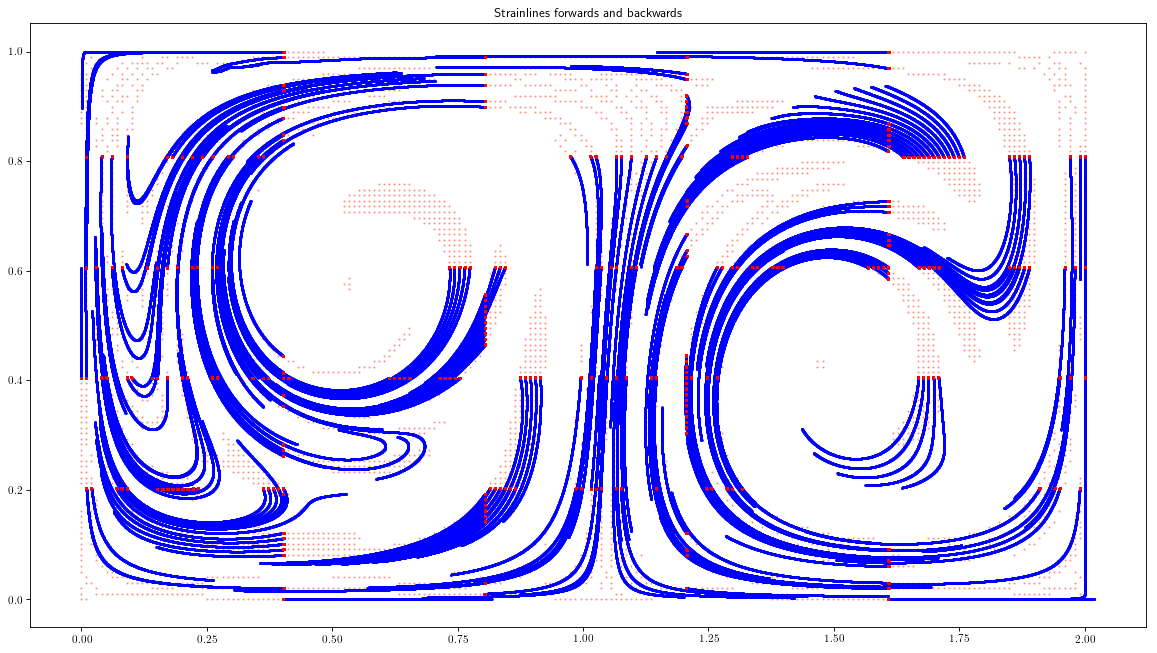

In [41]:
plt.figure(figsize=(18,10),dpi=80)
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,alpha=0.5)
for strainline in strainlines_forwards2:
    #if strainline.long_enough(): #and not strainline.has_failed_continiously():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],s=2,c='b')
for strainline in strainlines_backwards2:
    #if strainline.long_enough():
        plt.scatter(strainline.entire_trajectory()[:,0],strainline.entire_trajectory()[:,1],s=2,c='r')

plt.title(r'Strainlines forwards and backwards')
#plt.xlim(1.45,1.8)
#plt.ylim(0.35,0.75)
plt.show()


In [44]:
strainlines_backwards2[0].entire_trajectory()[:10,:]

array([[  0.00000000e+00,   4.04040404e-01],
       [  1.06448600e-20,   4.03540404e-01],
       [  1.06572599e-20,   4.03040404e-01],
       [  1.06448600e-20,   4.03540404e-01],
       [  1.06572599e-20,   4.03040404e-01],
       [  1.06448600e-20,   4.03540404e-01],
       [  1.06572599e-20,   4.03040404e-01],
       [  1.06448600e-20,   4.03540404e-01],
       [  1.06572599e-20,   4.03040404e-01],
       [  1.06448600e-20,   4.03540404e-01]])

In [45]:
strainlines_forwards2[0].entire_trajectory()[:10,:]

array([[  0.00000000e+00,   4.04040404e-01],
       [ -1.06448600e-20,   4.04540404e-01],
       [ -4.25630950e-20,   4.05040404e-01],
       [ -9.57303603e-20,   4.05540404e-01],
       [ -1.70122541e-19,   4.06040404e-01],
       [ -2.65715752e-19,   4.06540404e-01],
       [ -3.82486337e-19,   4.07040404e-01],
       [ -5.20410868e-19,   4.07540404e-01],
       [ -6.79466145e-19,   4.08040404e-01],
       [ -8.59629193e-19,   4.08540404e-01]])

# Neste steg: Mat inn to første punkter i forward, tving til å ta motsatt steg --> Xi1 ut fra pos_start, bare at med negativt fortegn

In [368]:
strainlines_forwards2[strainlineno].entire_trajectory()[:10,:]

array([[ 1.20603015,  0.02020202],
       [ 1.20652355,  0.02012106],
       [ 1.20701705,  0.02004068],
       [ 1.20751064,  0.01996089],
       [ 1.20800433,  0.01988167],
       [ 1.2084981 ,  0.01980303],
       [ 1.20899197,  0.01972496],
       [ 1.20948593,  0.01964745],
       [ 1.20997997,  0.0195705 ],
       [ 1.2104741 ,  0.01949411]])

In [369]:
strainlines_backwards2[strainlineno].entire_trajectory()[:10,:]

array([[ 1.20603015,  0.02020202],
       [ 1.20652355,  0.02012106],
       [ 1.20701705,  0.02004068],
       [ 1.20751064,  0.01996089],
       [ 1.20800433,  0.01988167],
       [ 1.2084981 ,  0.01980303],
       [ 1.20899197,  0.01972496],
       [ 1.20948593,  0.01964745],
       [ 1.20997997,  0.0195705 ],
       [ 1.2104741 ,  0.01949411]])

In [370]:
pos = g0[:,strainlineno]

In [371]:
pos

array([ 1.20603015,  0.02020202])

In [372]:
rhs = LinearSpecialDerivative(nx,ny,grid,xi1)

In [373]:
t = 0
xi0 = rhs(t,pos)
rhs._reverse()
xi1 = rhs(t,pos)

In [374]:
xi0

array([-0.98670621,  0.16251419])

In [375]:
xi1

array([ 0.98670621, -0.16251419])

In [69]:
def foo():
    f = FloatProgress(min=0,max=1000,description='Progress bar')
    display(f)
    
    def fu(f):
        for j in range(1000):
            f.value+=1
    fu(f)

p = mp.Process(target=foo,args=())
p.start()
p.join()
    
#foo()

In [42]:
class Strainline:
    def __init__(self,startpoint,pos_init,lmbd1_spline,lmbd2_spline,l_min,l_f_max):
        self._pos = [startpoint.T]
        self._lmbd1_spline = lmbd1_spline
        self._lmbd2_spline = lmbd2_spline
        self._length = 0.
        self._minimum_length = l_min
        self._sufficient_length = False
        self._maximum_continious_failure_length = l_f_max
        self._continious_failure_length = 0.
        self._continious_failure = False
        self._stationary_endpoint = False
        self._num_points = 1
    
    def current_alpha(self):
        lmbd1 = self._lmbd1_spline.ev(self.current_position()[1], self.current_position()[0])
        lmbd2 = self._lmbd2_spline.ev(self.current_position()[1], self.current_position()[0])
        return ((lmbd1-lmbd2)/(lmbd1+lmbd2))**2
    
    def current_position(self):
        return np.asarray(self._pos[-1])
    
    def long_enough(self):
        return self._sufficient_length
    
    def _is_long_enough(self):
        self._sufficient_length = True
    
    def failed_continiously(self):
        return self._continious_failure
    
    def _has_failed_continiously(self):
        self._continious_failure = True
    
    def _set_continious_failure_length(self,length):
        self._continious_failure_length = length
    
    def reached_stationary_point(self):
        return self._stationary_endpoint
    
    def _has_reached_stationary_point(self):
        self._stationary_endpoint = True
    
    def get_length(self):
        return self._length
    
    def get_continious_failure_length(self):
        return self._continious_failure_length
    
    def get_num_points(self):
        return self._num_points
    
    def _set_length(self,length):
        self._length = length
        
    def _append(self,pos):
        self._pos.append(pos.T)
        self._num_points += 1
        
    def average_lmbd2(self):
        return np.mean(self._lmbd2_spline.ev(self.entire_trajectory()[:,1],self.entire_trajectory()[:,0]))
    
    def entire_trajectory(self):
        return np.asarray(self._pos)
    
    def _merge(self,other):
        self._pos = self._pos[::-1] + other._pos[1:]
        self._num_points += other._num_points - 1
        self._length += other._length
        self._sufficient_length = self._length > self._minimum_length
        self._continious_failure = self._continious_failure or other._continious_failure
        self._stationary_endpoint = self._stationary_endpoint or other._stationary_endpoint

0

In [80]:
xi1.shape

(2, 20000)

In [81]:
ksi1 = (xi1.reshape(2,nx,ny).T).reshape(2,nx*ny)

In [153]:
ksi1 = xi1.reshape(2,nx,ny)
ksi2 = xi2.reshape(2,nx,ny)
l1 = lmbd1.reshape(nx,ny)
l2 = lmbd2.reshape(nx,ny)
l2l = lapl_lmbd2.reshape(nx,ny)

In [120]:
ksi1 = ksi1.T

In [248]:
l2l[50,4]

-405778.72550128581

In [175]:
L2 = lmbd2_.reshape(nx+4,ny+4)[1:-1,1:-1]

In [181]:
L2[51,4]

958.87094988006095

In [160]:
dx_main = (x_max-x_min)/(nx-1)
dy_main = (y_max-y_min)/(ny-1)

In [161]:
dx_main

0.010050251256281407

In [162]:
dy_main

0.010101010101010102

In [190]:
x[1]-x[0]

0.010050251256281407

In [191]:
y[1]-y[0]

0.010101010101010102

In [194]:
g0.shape

(2, 299)

In [200]:
g0[:,0]

array([ 0.       ,  0.4040404])

In [201]:
idx = np.argsort(g0[0,:])

In [203]:
g0[0,idx]

array([ 0.        ,  0.01005025,  0.01005025,  0.01005025,  0.01005025,
        0.0201005 ,  0.03015075,  0.04020101,  0.04020101,  0.05025126,
        0.06030151,  0.06030151,  0.07035176,  0.08040201,  0.08040201,
        0.09045226,  0.09045226,  0.09045226,  0.10050251,  0.13065327,
        0.14070352,  0.15075377,  0.15075377,  0.15075377,  0.16080402,
        0.17085427,  0.17085427,  0.17085427,  0.17085427,  0.18090452,
        0.18090452,  0.19095477,  0.19095477,  0.20100503,  0.20100503,
        0.20100503,  0.21105528,  0.21105528,  0.22110553,  0.22110553,
        0.22110553,  0.23115578,  0.23115578,  0.24120603,  0.26130653,
        0.26130653,  0.26130653,  0.27135678,  0.27135678,  0.29145729,
        0.30150754,  0.34170854,  0.35175879,  0.36180905,  0.36180905,
        0.36180905,  0.3718593 ,  0.3718593 ,  0.38190955,  0.3919598 ,
        0.40201005,  0.40201005,  0.40201005,  0.40201005,  0.40201005,
        0.40201005,  0.40201005,  0.40201005,  0.40201005,  0.40

In [205]:
g0[1,idx]

array([ 0.4040404 ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
        0.2020202 ,  0.60606061,  0.4040404 ,  0.80808081,  0.4040404 ,
        0.60606061,  0.80808081,  0.2020202 ,  0.2020202 ,  0.60606061,
        0.80808081,  0.4040404 ,  0.2020202 ,  0.4040404 ,  0.60606061,
        0.4040404 ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.2020202 ,
        0.80808081,  0.60606061,  0.2020202 ,  0.4040404 ,  0.2020202 ,
        0.80808081,  0.60606061,  0.2020202 ,  0.4040404 ,  0.80808081,
        0.2020202 ,  0.2020202 ,  0.4040404 ,  0.2020202 ,  0.60606061,
        0.80808081,  0.2020202 ,  0.60606061,  0.80808081,  0.80808081,
        0.4040404 ,  0.60606061,  0.4040404 ,  0.60606061,  0.80808081,
        0.80808081,  0.4040404 ,  0.80808081,  0.80808081,  0.2020202 ,
        0.4040404 ,  0.2020202 ,  0.4040404 ,  0.2020202 ,  0.2020202 ,
        0.84848485,  0.41414141,  0.44444444,  0.83838384,  0.87878788,
        0.4040404 ,  0.92929293,  0.93939394,  0.98989899,  1.  

In [206]:
psi = g0[:,idx]

In [208]:
psi[:,1]

array([ 0.01005025,  0.2020202 ])

In [215]:
import operator 
psi = sorted(g0,key=operator.itemgetter(1))
psi = sorted(psi,key=operator.itemgetter(0))

In [216]:
psi

[array([ 0.        ,  0.01005025,  0.01005025,  0.01005025,  0.01005025,
         0.0201005 ,  0.03015075,  0.04020101,  0.04020101,  0.05025126,
         0.06030151,  0.06030151,  0.07035176,  0.08040201,  0.08040201,
         0.09045226,  0.09045226,  0.09045226,  0.10050251,  0.13065327,
         0.14070352,  0.15075377,  0.15075377,  0.15075377,  0.16080402,
         0.17085427,  0.17085427,  0.17085427,  0.17085427,  0.18090452,
         0.18090452,  0.19095477,  0.19095477,  0.20100503,  0.20100503,
         0.20100503,  0.21105528,  0.21105528,  0.22110553,  0.22110553,
         0.22110553,  0.23115578,  0.23115578,  0.24120603,  0.26130653,
         0.26130653,  0.26130653,  0.27135678,  0.27135678,  0.29145729,
         0.30150754,  0.34170854,  0.35175879,  0.36180905,  0.36180905,
         0.36180905,  0.3718593 ,  0.3718593 ,  0.38190955,  0.3919598 ,
         0.40201005,  0.40201005,  0.40201005,  0.40201005,  0.40201005,
         0.40201005,  0.40201005,  0.40201005,  0.4

In [219]:
np.size(g0,1)

299

In [223]:
xs = np.unique(g0[0])
listx = [[] for j in range(np.size(xs))]

for j in range(np.size(g0,1)):
    for i in range(np.size(xs)):
        if g0[0,j] == xs[i]:
            listx[i].append(g0[1,j])
            break


In [235]:
listx[25]
    

[0.80808080808080818]

In [236]:
xs[25]

0.29145728643216079

In [230]:
xs.shape

(125,)

In [243]:
grid.reshape(2,nx,ny)[1,0,:]

array([ 0.        ,  0.01010101,  0.02020202,  0.03030303,  0.04040404,
        0.05050505,  0.06060606,  0.07070707,  0.08080808,  0.09090909,
        0.1010101 ,  0.11111111,  0.12121212,  0.13131313,  0.14141414,
        0.15151515,  0.16161616,  0.17171717,  0.18181818,  0.19191919,
        0.2020202 ,  0.21212121,  0.22222222,  0.23232323,  0.24242424,
        0.25252525,  0.26262626,  0.27272727,  0.28282828,  0.29292929,
        0.3030303 ,  0.31313131,  0.32323232,  0.33333333,  0.34343434,
        0.35353535,  0.36363636,  0.37373737,  0.38383838,  0.39393939,
        0.4040404 ,  0.41414141,  0.42424242,  0.43434343,  0.44444444,
        0.45454545,  0.46464646,  0.47474747,  0.48484848,  0.49494949,
        0.50505051,  0.51515152,  0.52525253,  0.53535354,  0.54545455,
        0.55555556,  0.56565657,  0.57575758,  0.58585859,  0.5959596 ,
        0.60606061,  0.61616162,  0.62626263,  0.63636364,  0.64646465,
        0.65656566,  0.66666667,  0.67676768,  0.68686869,  0.69

In [246]:
grid_.reshape(2,nx+4,ny+4)[0,1:-1,0]

array([-0.01005025,  0.        ,  0.01005025,  0.0201005 ,  0.03015075,
        0.04020101,  0.05025126,  0.06030151,  0.07035176,  0.08040201,
        0.09045226,  0.10050251,  0.11055276,  0.12060302,  0.13065327,
        0.14070352,  0.15075377,  0.16080402,  0.17085427,  0.18090452,
        0.19095477,  0.20100503,  0.21105528,  0.22110553,  0.23115578,
        0.24120603,  0.25125628,  0.26130653,  0.27135678,  0.28140704,
        0.29145729,  0.30150754,  0.31155779,  0.32160804,  0.33165829,
        0.34170854,  0.35175879,  0.36180905,  0.3718593 ,  0.38190955,
        0.3919598 ,  0.40201005,  0.4120603 ,  0.42211055,  0.4321608 ,
        0.44221106,  0.45226131,  0.46231156,  0.47236181,  0.48241206,
        0.49246231,  0.50251256,  0.51256281,  0.52261307,  0.53266332,
        0.54271357,  0.55276382,  0.56281407,  0.57286432,  0.58291457,
        0.59296482,  0.60301508,  0.61306533,  0.62311558,  0.63316583,
        0.64321608,  0.65326633,  0.66331658,  0.67336683,  0.68

In [261]:
np.save('por_señor_northbranchx2.npy',xi2)

In [380]:
xi1 = xi1_[:,_inner_mask]

(0, 0.05)

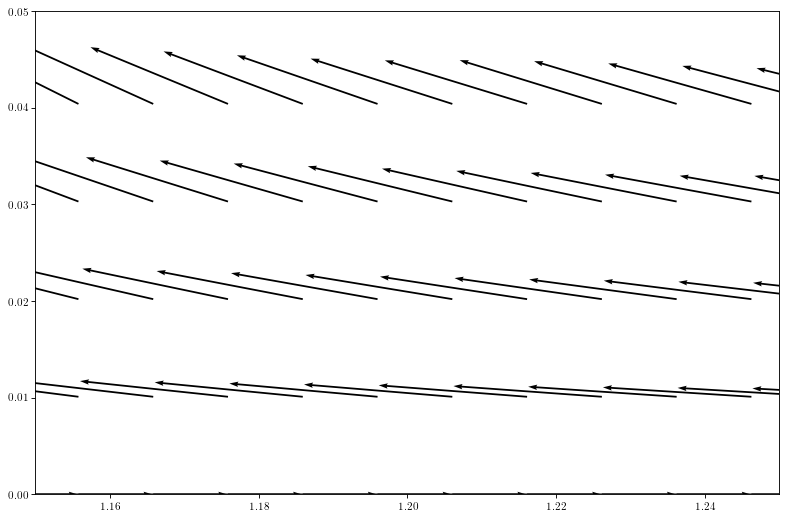

In [391]:
plt.figure(figsize=(12,8),dpi=80)
plt.quiver(grid[0],grid[1],xi1[0],xi1[1],scale=5)
plt.xlim(1.15,1.25)
plt.ylim(0,0.05)

In [388]:
xi1[0].shape

(20000,)